## Calibration Results

In [1]:
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle as pkl

In [2]:
build_path = Path('build') / 'calibration_table'
pattern = re.compile('calibration.*txt')
calibration_results = [x for x in build_path.iterdir() if x.is_file() and re.match(pattern, x.name)]

In [3]:
results = []
columns = None
for p in calibration_results:
    with open(p, 'r') as f:
        try:
            columns, result = [line.strip().split(',') for line in f.readlines()]
        except Exception as e:
            print(p)
            print(e)
    model, dataset, *stats = p.name.split('-')
    stats = '-'.join(stats).replace('.txt', '')
    result.append(stats)
    results.append(result)

In [4]:
calibration_table = pd.DataFrame.from_records(results, columns=[*columns, 'Statistic'])

In [5]:
# trunc_num = lambda x: (round(float(x.split('/')[0]), 4), round(float(x.split('/')[1]), 5))

In [6]:
# trunc_num = lambda x: round(float(x.split('/')[0]), 4)

In [7]:
trunc_num = lambda x: float(x.split('/')[0])

In [8]:
for col in ['Item Pop', 'User Act', 'I-I Sim', 'U-U Sim']:
    calibration_table[col] = calibration_table[col].map(trunc_num)

In [9]:
dataname = dict(az_music_5core='AZM5', ml_1m='ML1M', steam_video_game='STMV1')
statsname = {'all': 'Linear Combined', 'icorr': 'I-I Sim', 'ucorr': 'U-U Sim', 'item-pop': 'Item Pop', 'user-act': 'User Act'}
calibration_table['Data'] = calibration_table['Data'].map(dataname.get)
calibration_table['Statistic'] = calibration_table['Statistic'].map(statsname.get)
calibration_table.groupby(['Statistic', 'Data', 'Pref', 'Obs']).sum().head()

Item Pop  User Act   I-I Sim   U-U Sim
Statistic Data Pref Obs                                         
I-I Sim   AZM5 IBP  Pop   1.750391  1.201648  0.021876  7.133677
                    Unif  4.114631  0.935025  0.022315  0.155890
               LDA  Pop   2.086991  0.480340  0.004397  0.074170
                    Unif  1.624205  2.465712  0.007599  0.016325
          ML1M IBP  Pop   1.183568  0.361160  0.081139  0.294412

In [10]:
calibration_table = calibration_table[calibration_table['Statistic'] != 'Linear Combined'].copy()

In [11]:
def draw_calibration_heatmap(*args, **kwargs):
    data = kwargs.pop('data').sort_values(['Pref', 'Obs']).drop(['Data', 'Statistic'], axis=1).set_index(['Pref', 'Obs'])
    sns.heatmap(data, annot=True, fmt='.4f', cbar=False)
    plt.yticks(rotation=0)

In [12]:
# g = sns.FacetGrid(calibration_table, col='Statistic', row='Data', height=3, margin_titles=True)
# g.map_dataframe(draw_calibration_heatmap)

In [13]:
def compute_relative_kl(data):
    relative_values = data
    for stats in ['I-I Sim', 'U-U Sim', 'Item Pop', 'User Act']:
        best_values = relative_values[relative_values['Statistic'] == stats][['Data', 'Pref', 'Obs', stats]]
        relative_values = relative_values.merge(best_values, on=['Data', 'Pref', 'Obs'], suffixes=('', '_best'), how='left')
        relative_values[f'{stats}_Rel'] = relative_values[stats] / relative_values[f'{stats}_best']
        relative_values = relative_values.drop([stats, f'{stats}_best'], axis=1)
    return relative_values

In [14]:
# compute_relative_kl(calibration_table).groupby(['Statistic', 'Data', 'Pref', 'Obs']).sum().head()

In [15]:
best_calibrate_scores = calibration_table.groupby(['Data', 'Statistic'])[['I-I Sim', 'Item Pop', 'U-U Sim', 'User Act']].min().apply(lambda x: x[x.name[1]], axis=1).rename('best_score').reset_index()

In [16]:
best_calibrate_scores.pivot_table(index='Data', columns='Statistic', values='best_score').reset_index()

Statistic,Data,I-I Sim,Item Pop,U-U Sim,User Act
0,AZM5,0.004397,0.419039,0.000941,0.035033
1,ML1M,0.002478,0.458239,0.006463,0.262218
2,STMV1,0.062484,0.383821,0.132178,0.451621


In [17]:
merged = calibration_table.merge(best_calibrate_scores.pivot_table(index='Data', columns='Statistic', values='best_score').reset_index(), 
                        on='Data', how='left', suffixes=['', '_best'])
merged.head()

,Data,Pref,Obs,Item Pop,User Act,I-I Sim,U-U Sim,Statistic,I-I Sim_best,Item Pop_best,U-U Sim_best,User Act_best
0,STMV1,LDA,Unif,0.993756,0.505100,0.514396,0.360627,I-I Sim,0.062484,0.383821,0.132178,0.451621
1,AZM5,LDA,Pop,0.440086,0.291708,0.064703,0.021277,U-U Sim,0.004397,0.419039,0.000941,0.035033
2,AZM5,IBP,Pop,4.415213,0.039594,2.181873,0.065609,User Act,0.004397,0.419039,0.000941,0.035033
3,AZM5,LDA,Unif,1.624205,2.465712,0.007599,0.016325,I-I Sim,0.004397,0.419039,0.000941,0.035033
4,ML1M,IBP,Pop,0.794701,3.957774,1.063939,1.322008,Item Pop,0.002478,0.458239,0.006463,0.262218


In [18]:
for metric in ['I-I Sim', 'Item Pop', 'U-U Sim', 'User Act']:
    merged[f'{metric}_relative'] = (merged[metric] - merged[f'{metric}_best']) / merged[f'{metric}_best']

In [19]:
merged.head()

,Data,Pref,Obs,Item Pop,User Act,I-I Sim,U-U Sim,Statistic,I-I Sim_best,Item Pop_best,U-U Sim_best,User Act_best,I-I Sim_relative,Item Pop_relative,U-U Sim_relative,User Act_relative
0,STMV1,LDA,Unif,0.993756,0.505100,0.514396,0.360627,I-I Sim,0.062484,0.383821,0.132178,0.451621,7.232494,1.589112,1.728351,0.118416
1,AZM5,LDA,Pop,0.440086,0.291708,0.064703,0.021277,U-U Sim,0.004397,0.419039,0.000941,0.035033,13.714324,0.050226,21.600399,7.326707
2,AZM5,IBP,Pop,4.415213,0.039594,2.181873,0.065609,User Act,0.004397,0.419039,0.000941,0.035033,495.186210,9.536527,68.689528,0.130186
3,AZM5,LDA,Unif,1.624205,2.465712,0.007599,0.016325,I-I Sim,0.004397,0.419039,0.000941,0.035033,0.728076,2.876027,16.340201,69.382878
4,ML1M,IBP,Pop,0.794701,3.957774,1.063939,1.322008,Item Pop,0.002478,0.458239,0.006463,0.262218,428.284611,0.734251,203.560424,14.093468


In [20]:
merged[merged['I-I Sim_relative'] < 0]

,Data,Pref,Obs,Item Pop,User Act,I-I Sim,U-U Sim,Statistic,I-I Sim_best,Item Pop_best,U-U Sim_best,User Act_best,I-I Sim_relative,Item Pop_relative,U-U Sim_relative,User Act_relative
33,STMV1,IBP,Pop,0.893767,1.417139,0.062016,0.462335,U-U Sim,0.062484,0.383821,0.132178,0.451621,-0.007484,1.328605,2.497829,2.137898


In [21]:
merged['best'] = merged[[f'{x}_relative' for x in ['I-I Sim', 'Item Pop', 'U-U Sim', 'User Act']]].sum(axis=1) / 4

In [22]:
merged.head()

,Data,Pref,Obs,Item Pop,User Act,I-I Sim,U-U Sim,Statistic,I-I Sim_best,Item Pop_best,U-U Sim_best,User Act_best,I-I Sim_relative,Item Pop_relative,U-U Sim_relative,User Act_relative,best
0,STMV1,LDA,Unif,0.993756,0.505100,0.514396,0.360627,I-I Sim,0.062484,0.383821,0.132178,0.451621,7.232494,1.589112,1.728351,0.118416,2.667094
1,AZM5,LDA,Pop,0.440086,0.291708,0.064703,0.021277,U-U Sim,0.004397,0.419039,0.000941,0.035033,13.714324,0.050226,21.600399,7.326707,10.672914
2,AZM5,IBP,Pop,4.415213,0.039594,2.181873,0.065609,User Act,0.004397,0.419039,0.000941,0.035033,495.186210,9.536527,68.689528,0.130186,143.385613
3,AZM5,LDA,Unif,1.624205,2.465712,0.007599,0.016325,I-I Sim,0.004397,0.419039,0.000941,0.035033,0.728076,2.876027,16.340201,69.382878,22.331795
4,ML1M,IBP,Pop,0.794701,3.957774,1.063939,1.322008,Item Pop,0.002478,0.458239,0.006463,0.262218,428.284611,0.734251,203.560424,14.093468,161.668188


### Best results

In [27]:
merged.sort_values(['Data', 'best']).groupby('Data').head(2)
# merged.loc[merged.groupby('Data', as_index=False)['best'].apply(lambda x: x.idxmin()), :]

,Data,Pref,Obs,Item Pop,User Act,I-I Sim,U-U Sim,Statistic,I-I Sim_best,Item Pop_best,U-U Sim_best,User Act_best,I-I Sim_relative,Item Pop_relative,U-U Sim_relative,User Act_relative,best
39,AZM5,LDA,Unif,0.789527,0.195459,0.014315,0.000941,U-U Sim,0.004397,0.419039,0.000941,0.035033,2.255485,0.884139,0.000000,4.579311,1.929734
47,AZM5,IBP,Unif,2.744011,0.469795,0.023800,0.005710,U-U Sim,0.004397,0.419039,0.000941,0.035033,4.412541,5.548347,5.065402,12.410122,6.859103
28,ML1M,LDA,Pop,0.489836,0.477945,0.002478,0.162549,I-I Sim,0.002478,0.458239,0.006463,0.262218,0.000000,0.068955,24.151963,0.822703,6.260905
10,ML1M,LDA,Pop,0.589857,0.383090,0.097900,0.045811,U-U Sim,0.002478,0.458239,0.006463,0.262218,38.501084,0.287225,6.088601,0.460961,11.334468
33,STMV1,IBP,Pop,0.893767,1.417139,0.062016,0.462335,U-U Sim,0.062484,0.383821,0.132178,0.451621,-0.007484,1.328605,2.497829,2.137898,1.489212
36,STMV1,IBP,Pop,0.908199,1.414001,0.062484,0.462054,I-I Sim,0.062484,0.383821,0.132178,0.451621,0.000000,1.366204,2.495702,2.130948,1.498214


### Calibration table

In [24]:
merged[(merged['Data'] == 'ML1M') & (merged['Statistic'] == 'I-I Sim')].sort_index(axis=1).sort_values(['Pref', 'Obs'])

,Data,I-I Sim,I-I Sim_best,I-I Sim_relative,Item Pop,Item Pop_best,Item Pop_relative,Obs,Pref,Statistic,U-U Sim,U-U Sim_best,U-U Sim_relative,User Act,User Act_best,User Act_relative,best
12,ML1M,0.081139,0.002478,31.738535,1.183568,0.458239,1.582863,Pop,IBP,I-I Sim,0.294412,0.006463,44.555694,0.361160,0.262218,0.377330,19.563605
24,ML1M,0.217963,0.002478,86.944894,0.845802,0.458239,0.845766,Unif,IBP,I-I Sim,0.185170,0.006463,27.652198,0.476612,0.262218,0.817620,29.065120
28,ML1M,0.002478,0.002478,0.000000,0.489836,0.458239,0.068955,Pop,LDA,I-I Sim,0.162549,0.006463,24.151963,0.477945,0.262218,0.822703,6.260905
18,ML1M,0.011134,0.002478,3.492328,0.459939,0.458239,0.003711,Unif,LDA,I-I Sim,0.354561,0.006463,53.862905,0.397015,0.262218,0.514066,14.468253


In [25]:
merged[(merged['Data'] == 'AZM5') & (merged['Statistic'] == 'U-U Sim')].sort_index(axis=1).sort_values(['Pref', 'Obs'])

,Data,I-I Sim,I-I Sim_best,I-I Sim_relative,Item Pop,Item Pop_best,Item Pop_relative,Obs,Pref,Statistic,U-U Sim,U-U Sim_best,U-U Sim_relative,User Act,User Act_best,User Act_relative,best
23,AZM5,0.061000,0.004397,12.872141,7.557304,0.419039,17.034856,Pop,IBP,U-U Sim,0.005908,0.000941,5.275715,0.192573,0.035033,4.496924,9.919909
47,AZM5,0.023800,0.004397,4.412541,2.744011,0.419039,5.548347,Unif,IBP,U-U Sim,0.005710,0.000941,5.065402,0.469795,0.035033,12.410122,6.859103
1,AZM5,0.064703,0.004397,13.714324,0.440086,0.419039,0.050226,Pop,LDA,U-U Sim,0.021277,0.000941,21.600399,0.291708,0.035033,7.326707,10.672914
39,AZM5,0.014315,0.004397,2.255485,0.789527,0.419039,0.884139,Unif,LDA,U-U Sim,0.000941,0.000941,0.000000,0.195459,0.035033,4.579311,1.929734


In [26]:
merged[(merged['Data'] == 'STMV1') & (merged['Statistic'] == 'U-U Sim')].sort_index(axis=1).sort_values(['Pref', 'Obs'])

,Data,I-I Sim,I-I Sim_best,I-I Sim_relative,Item Pop,Item Pop_best,Item Pop_relative,Obs,Pref,Statistic,U-U Sim,U-U Sim_best,U-U Sim_relative,User Act,User Act_best,User Act_relative,best
33,STMV1,0.062016,0.062484,-0.007484,0.893767,0.383821,1.328605,Pop,IBP,U-U Sim,0.462335,0.132178,2.497829,1.417139,0.451621,2.137898,1.489212
9,STMV1,0.177204,0.062484,1.836005,0.828047,0.383821,1.157379,Unif,IBP,U-U Sim,0.436395,0.132178,2.301576,1.413516,0.451621,2.129876,1.856209
32,STMV1,0.455624,0.062484,6.291896,0.991972,0.383821,1.584465,Pop,LDA,U-U Sim,0.132178,0.132178,0.000000,0.496147,0.451621,0.098593,1.993738
31,STMV1,0.517289,0.062484,7.278793,0.997597,0.383821,1.599120,Unif,LDA,U-U Sim,0.365639,0.132178,1.766270,0.496237,0.451621,0.098792,2.685744


## Simulation Results

In [2]:
build_path = Path('build') / 'simulation_results'
pattern = re.compile('simulate.*pkl')
simulation_results = [x for x in build_path.iterdir() if x.is_file() and re.match(pattern, x.name)]

In [3]:
results = []
for p in simulation_results:
    with open(p, 'rb') as f:
        result = pkl.load(f)
        nalgos = len(result['algorithm'].unique())
        nruns = int(len(result) / nalgos)
        result['no'] = np.repeat(range(nruns), nalgos)
        model, dataset, *stats = p.name.split('-')
        stats = '-'.join(stats).replace('.pkl', '')
        _, pref_name, obs_name, _ = model.split('_')
        result['generator'] = pref_name
        result['sampler'] = obs_name
        result['stats_to_tune'] = stats
        result['dataset'] = dataset
        results.append(result)
results = pd.concat(results, axis=0, ignore_index=True)

In [4]:
results = results[results['dataset'] != 'ml_100k'].copy()

In [5]:
np.all(results.groupby(['dataset', 'stats_to_tune', 'generator', 'sampler', 'algorithm']).count().values == 100)

True

In [6]:
metric_mean = results[results['stats_to_tune'] != 'all'].groupby(['dataset', 'stats_to_tune', 'sampler', 'generator', 'algorithm']).agg(['mean', 'std']).stack(1).unstack(-2).unstack()[['precision_obs', 'precision_pref', 'recall_obs', 'recall_pref', 'recip_rank_obs', 'recip_rank_pref', 'ndcg_obs', 'ndcg_pref']]
metric_mean.to_csv('build/simulation_results/metric_mean.csv')
metric_mean.head()

precision_obs            \
algorithm                                             Oracle             
                                                        mean       std   
dataset        stats_to_tune sampler generator                           
az_music_5core icorr         pop     ibp            0.767199  0.037143   
                                     lda            0.101378  0.002560   
                             unif    ibp            0.090245  0.004320   
                                     lda            0.051484  0.002056   
               item-pop      pop     ibp            0.765780  0.006565   

                                                                              \
algorithm                                        Popular              Random   
                                                    mean       std      mean   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.059910  0.009051  0.003442   
                                     lda        0.008784  0.000375  0.001280   
                             unif    ibp        0.042293  0.002017  0.000108   
                                     lda        0.005494  0.000289  0.001305   
               item-pop      pop     ibp        0.006241  0.000343  0.000471   

                                                         precision_pref       \
algorithm                                                        Oracle        
                                                     std           mean  std   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.000558            1.0  0.0   
                                     lda        0.000071            1.0  0.0   
                             unif    ibp        0.000019            1.0  0.0   
                                     lda        0.000074            1.0  0.0   
               item-pop      pop     ibp        0.000040            1.0  0.0   

                                                                    ...  \
algorithm                                        Popular            ...   
                                                    mean       std  ...   
dataset        stats_to_tune sampler generator                      ...   
az_music_5core icorr         pop     ibp        0.105168  0.026989  ...   
                                     lda        0.051533  0.001118  ...   
                             unif    ibp        0.726370  0.027629  ...   
                                     lda        0.136167  0.005787  ...   
               item-pop      pop     ibp        0.007572  0.000393  ...   

                                                ndcg_obs                      \
algorithm                                        Popular              Random   
                                                    mean       std      mean   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.665727  0.046610  0.017067   
                                     lda        0.116894  0.007823  0.013744   
                             unif    ibp        0.065272  0.002445  0.000169   
                                     lda        0.043895  0.002519  0.009359   
               item-pop      pop     ibp        0.038414  0.002763  0.002320   

                                                         ndcg_pref            \
algorithm                                                   Oracle             
                                                     std      mean       std   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.001402  0.993759  0.001247   
                                     lda        0.000882  0.973638  0.001429   
                             unif    ibp        0.000050  0.2

In [8]:
metric_quantil = results[results['stats_to_tune'] != 'all'].groupby(['dataset', 'stats_to_tune', 'sampler', 'generator', 'algorithm']).quantile([0.025, 0.975])[['precision_obs', 'precision_pref', 'recall_obs', 'recall_pref', 'recip_rank_obs', 'recip_rank_pref', 'ndcg_obs', 'ndcg_pref']].unstack(-2).unstack()
metric_quantil.head()

precision_obs            \
algorithm                                             Oracle             
                                                       0.025     0.975   
dataset        stats_to_tune sampler generator                           
az_music_5core icorr         pop     ibp            0.697483  0.840092   
                                     lda            0.096713  0.106038   
                             unif    ibp            0.082993  0.098626   
                                     lda            0.047895  0.055542   
               item-pop      pop     ibp            0.753061  0.778031   

                                                                              \
algorithm                                        Popular              Random   
                                                   0.025     0.975     0.025   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.042806  0.079335  0.002475   
                                     lda        0.008130  0.009523  0.001124   
                             unif    ibp        0.038615  0.046118  0.000074   
                                     lda        0.004983  0.006060  0.001180   
               item-pop      pop     ibp        0.005640  0.006946  0.000408   

                                                         precision_pref        \
algorithm                                                        Oracle         
                                                   0.975          0.025 0.975   
dataset        stats_to_tune sampler generator                                  
az_music_5core icorr         pop     ibp        0.004681            1.0   1.0   
                                     lda        0.001395            1.0   1.0   
                             unif    ibp        0.000146            1.0   1.0   
                                     lda        0.001448            1.0   1.0   
               item-pop      pop     ibp        0.000543            1.0   1.0   

                                                                    ...  \
algorithm                                        Popular            ...   
                                                   0.025     0.975  ...   
dataset        stats_to_tune sampler generator                      ...   
az_music_5core icorr         pop     ibp        0.059471  0.168803  ...   
                                     lda        0.049467  0.053756  ...   
                             unif    ibp        0.678724  0.780092  ...   
                                     lda        0.123668  0.146201  ...   
               item-pop      pop     ibp        0.006847  0.008412  ...   

                                                ndcg_obs                      \
algorithm                                        Popular              Random   
                                                   0.025     0.975     0.025   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.545633  0.747782  0.014905   
                                     lda        0.102299  0.136756  0.012220   
                             unif    ibp        0.060741  0.070230  0.000094   
                                     lda        0.039486  0.048903  0.008138   
               item-pop      pop     ibp        0.032906  0.043956  0.001889   

                                                         ndcg_pref            \
algorithm                                                   Oracle             
                                                   0.975     0.025     0.975   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.019820  0.990822  0.995668   
                                     lda        0.015351  0.970844  0.976206   
                             unif    ibp        0.00

In [7]:
def extract_result(sims_results, metric='precision', stats_to_tune='icorr', dataset=None):
    """Extracts simulation results for a given evaluation metric, tuned statistic and dataset"""
    obs_label = ''.join([metric, '_obs'])
    pref_label = ''.join([metric, '_pref'])
    result = sims_results[['algorithm', obs_label, pref_label, 'no', 'generator', 'sampler', 'stats_to_tune', 'dataset']]
    if stats_to_tune:
        result = result[result['stats_to_tune'] == stats_to_tune]
    if dataset:
        result = result[result['dataset'] == dataset]
    result = result.rename(columns={obs_label: 'observation', pref_label: 'preference'})
    result['error'] = result['observation'] - result['preference']
    return result

In [8]:
def rank_algos(data, metric='precision', stats_to_tune='icorr', algo_pair=('Oracle', 'Popular')):
    data_pivot = data.drop(['error', 'stats_to_tune'], axis=1, errors='ignore').pivot_table(index=['no', 'generator', 'sampler', 'dataset'], columns='algorithm')
    algo1, algo2 = algo_pair
    obs_rank = (data_pivot['observation'][algo1] >= data_pivot['observation'][algo2])
    obs_rank = obs_rank.groupby(level=['generator', 'sampler', 'dataset']).sum().rename('observation')
    pref_rank = (data_pivot['preference'][algo1] >= data_pivot['preference'][algo2])
    pref_rank = pref_rank.groupby(level=['generator', 'sampler', 'dataset']).sum().rename('preference')
    return pd.concat([obs_rank, pref_rank], axis=1).stack().rename('count').reset_index().rename(columns={'level_3': 'data_model'})

In [9]:
def plot_rank_percentage(data, style='seaborn-paper', palette='husl', **kwargs):
    with plt.style.context(style), sns.color_palette(palette):
        g = sns.FacetGrid(data, row='generator', col='sampler', 
                          sharey=False, sharex=True, 
                          height=5, margin_titles=True, legend_out=True)
        g = (g.map(sns.barplot, 'dataset', 'count', 'data_model', **kwargs)
             .add_legend())
        plt.show()

In [10]:
results['sampler'] = results['sampler'].str.capitalize()
results['generator'] = results['generator'].str.upper()
dataname = dict(az_music_5core='AZM5', ml_1m='ML1M', steam_video_game='STMV1')
results['dataset'] = results['dataset'].map(dataname.get)
results.head()

,algorithm,precision_obs,recall_obs,recip_rank_obs,ndcg_obs,precision_pref,recall_pref,recip_rank_pref,ndcg_pref,no,generator,sampler,stats_to_tune,dataset
0,Oracle,0.058473,0.848958,0.145906,0.269352,1.000000,0.849363,1.000000,0.904570,0,LDA,Unif,all,AZM5
1,Popular,0.002563,0.057949,0.013114,0.018387,0.062563,0.053971,0.217705,0.059340,0,LDA,Unif,all,AZM5
2,Random,0.000610,0.013719,0.003146,0.004298,0.016726,0.014412,0.064261,0.014177,0,LDA,Unif,all,AZM5
3,Oracle,0.057165,0.849231,0.141158,0.267481,1.000000,0.852062,1.000000,0.906257,1,LDA,Unif,all,AZM5
4,Popular,0.002400,0.053515,0.013575,0.017804,0.059906,0.052061,0.225690,0.058601,1,LDA,Unif,all,AZM5


In [11]:
def get_data(results, stats_data=(('icorr', 'ML1M'), ('ucorr', 'AZM5'), ('ucorr', 'STMV1'))):
    data_result = []
    for stats, d in stats_data:
        for metric in ['precision', 'recall', 'recip_rank', 'ndcg']:
            result = extract_result(results, metric=metric, stats_to_tune=stats, dataset=d).drop(['stats_to_tune'], axis=1)
            result['metric'] = metric
            result['model'] = result[['generator', 'sampler']].apply(lambda x: '-'.join([x[0], x[1]]), axis=1)
            data_result.append(result)
    return pd.concat(data_result, ignore_index=True)

In [12]:
best_fit_results = get_data(results)
best_fit_results.head()

,algorithm,observation,preference,no,generator,sampler,dataset,error,metric,model
0,Oracle,0.353980,1.000000,0,LDA,Pop,ML1M,-0.646020,precision,LDA-Pop
1,Popular,0.119106,0.441086,0,LDA,Pop,ML1M,-0.321980,precision,LDA-Pop
2,Random,0.015805,0.104579,0,LDA,Pop,ML1M,-0.088775,precision,LDA-Pop
3,Oracle,0.351831,1.000000,1,LDA,Pop,ML1M,-0.648169,precision,LDA-Pop
4,Popular,0.110563,0.424295,1,LDA,Pop,ML1M,-0.313732,precision,LDA-Pop


In [13]:
metric_name = dict(precision='Precision', recall='Recall', recip_rank='MRR', ndcg='NDCG')
best_fit_results['metric'] = best_fit_results['metric'].map(metric_name.get)
best_fit_results.rename(columns={'generator': 'Pref', 'sampler': 'Obs', 'error': 'Error', 
                                 'algorithm': 'Algorithm', 'dataset': 'Data'}, inplace=True)
best_fit_results['Obs-Data'] = best_fit_results[['Obs', 'Data']].apply(lambda x: '-'.join([x[0], x[1]]), axis=1)
best_fit_results.head()

,Algorithm,observation,preference,no,Pref,Obs,Data,Error,metric,model,Obs-Data
0,Oracle,0.353980,1.000000,0,LDA,Pop,ML1M,-0.646020,Precision,LDA-Pop,Pop-ML1M
1,Popular,0.119106,0.441086,0,LDA,Pop,ML1M,-0.321980,Precision,LDA-Pop,Pop-ML1M
2,Random,0.015805,0.104579,0,LDA,Pop,ML1M,-0.088775,Precision,LDA-Pop,Pop-ML1M
3,Oracle,0.351831,1.000000,1,LDA,Pop,ML1M,-0.648169,Precision,LDA-Pop,Pop-ML1M
4,Popular,0.110563,0.424295,1,LDA,Pop,ML1M,-0.313732,Precision,LDA-Pop,Pop-ML1M


In [14]:
metric = 'Precision'
data2plot = best_fit_results[best_fit_results['metric'] == 'Precision']
data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})
data2plot.head()

,Algorithm,observation,preference,no,Pref,Obs,Data,Precision-Error,metric,model,Obs-Data
0,Oracle,0.353980,1.000000,0,LDA,Pop,ML1M,-0.646020,Precision,LDA-Pop,Pop-ML1M
1,Popular,0.119106,0.441086,0,LDA,Pop,ML1M,-0.321980,Precision,LDA-Pop,Pop-ML1M
2,Random,0.015805,0.104579,0,LDA,Pop,ML1M,-0.088775,Precision,LDA-Pop,Pop-ML1M
3,Oracle,0.351831,1.000000,1,LDA,Pop,ML1M,-0.648169,Precision,LDA-Pop,Pop-ML1M
4,Popular,0.110563,0.424295,1,LDA,Pop,ML1M,-0.313732,Precision,LDA-Pop,Pop-ML1M


Boxplot

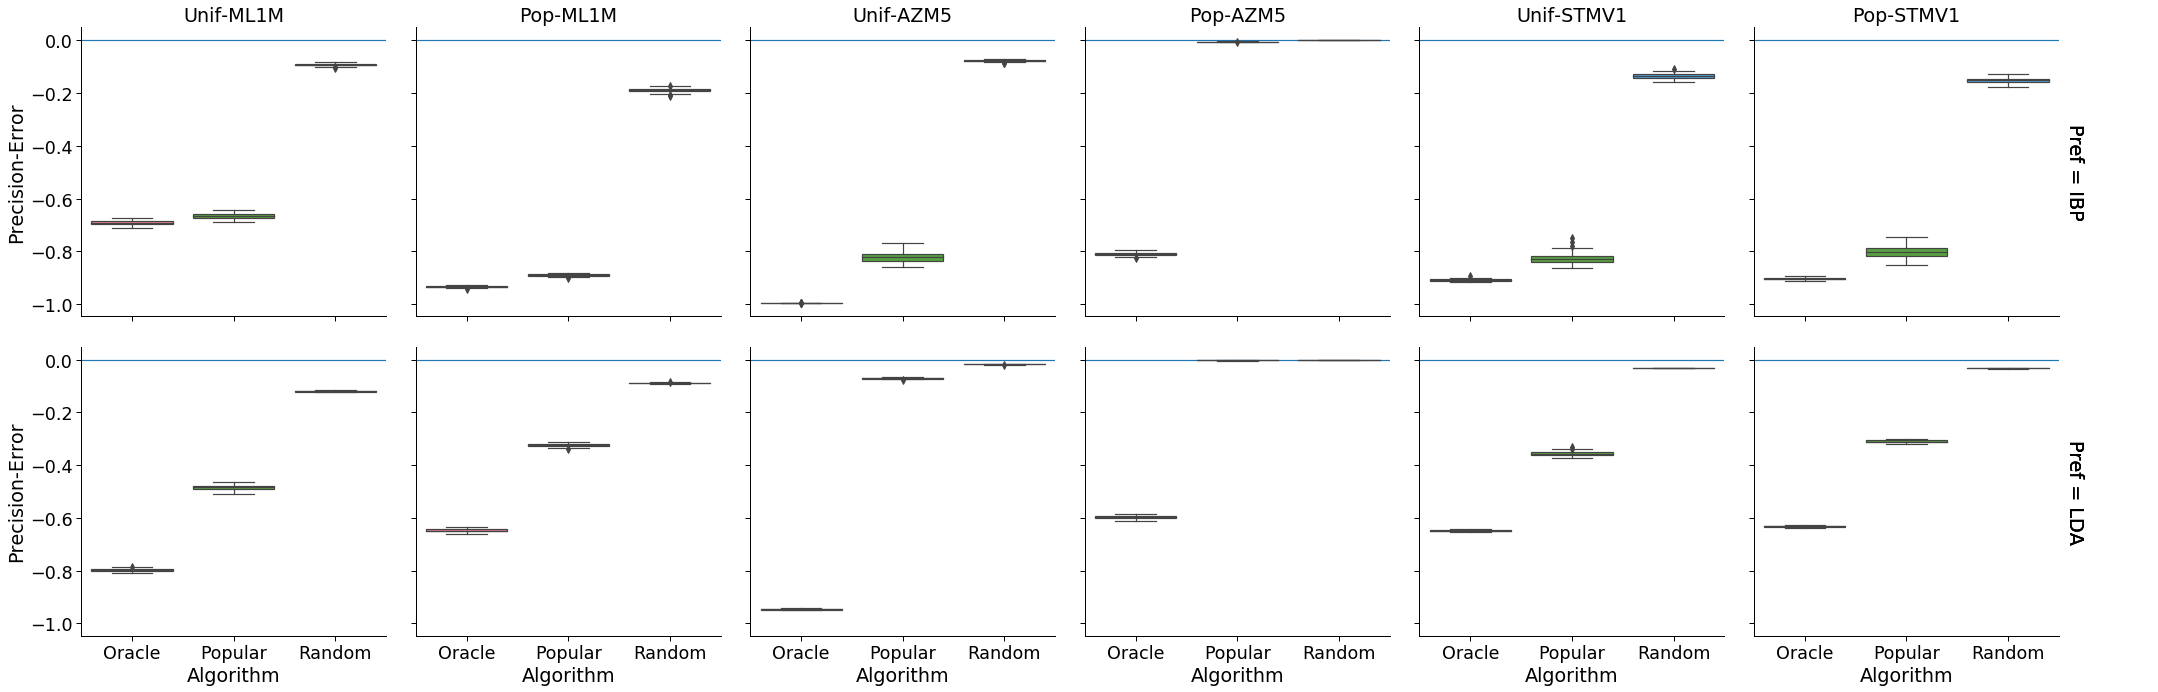

In [57]:
metric = 'Precision'
data2plot = best_fit_results[best_fit_results['metric'] == metric]
data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})
assert np.all(data2plot.groupby(['Data', 'metric', 'Pref', 'Obs', 'Algorithm']).count().values == 100)
# data2plot.head()

with sns.plotting_context('paper', 2):
    g = sns.FacetGrid(data2plot, col='Obs-Data', row='Pref', height=5, margin_titles=True, sharey=True, sharex=True,
                      col_order=['Unif-ML1M', 'Pop-ML1M', 'Unif-AZM5', 'Pop-AZM5', 'Unif-STMV1', 'Pop-STMV1'], 
                      row_order=['IBP', 'LDA'])
    g = g.map(plt.axhline)
    g = (g.map(sns.boxplot, 'Algorithm', f'{metric}-Error',
               palette='husl',
               order=['Oracle', 'Popular', 'Random'], 
               hue_order=['ML1M', 'AZM5', 'STMV1'])
         .add_legend().set_titles(col_template="{col_name}"))

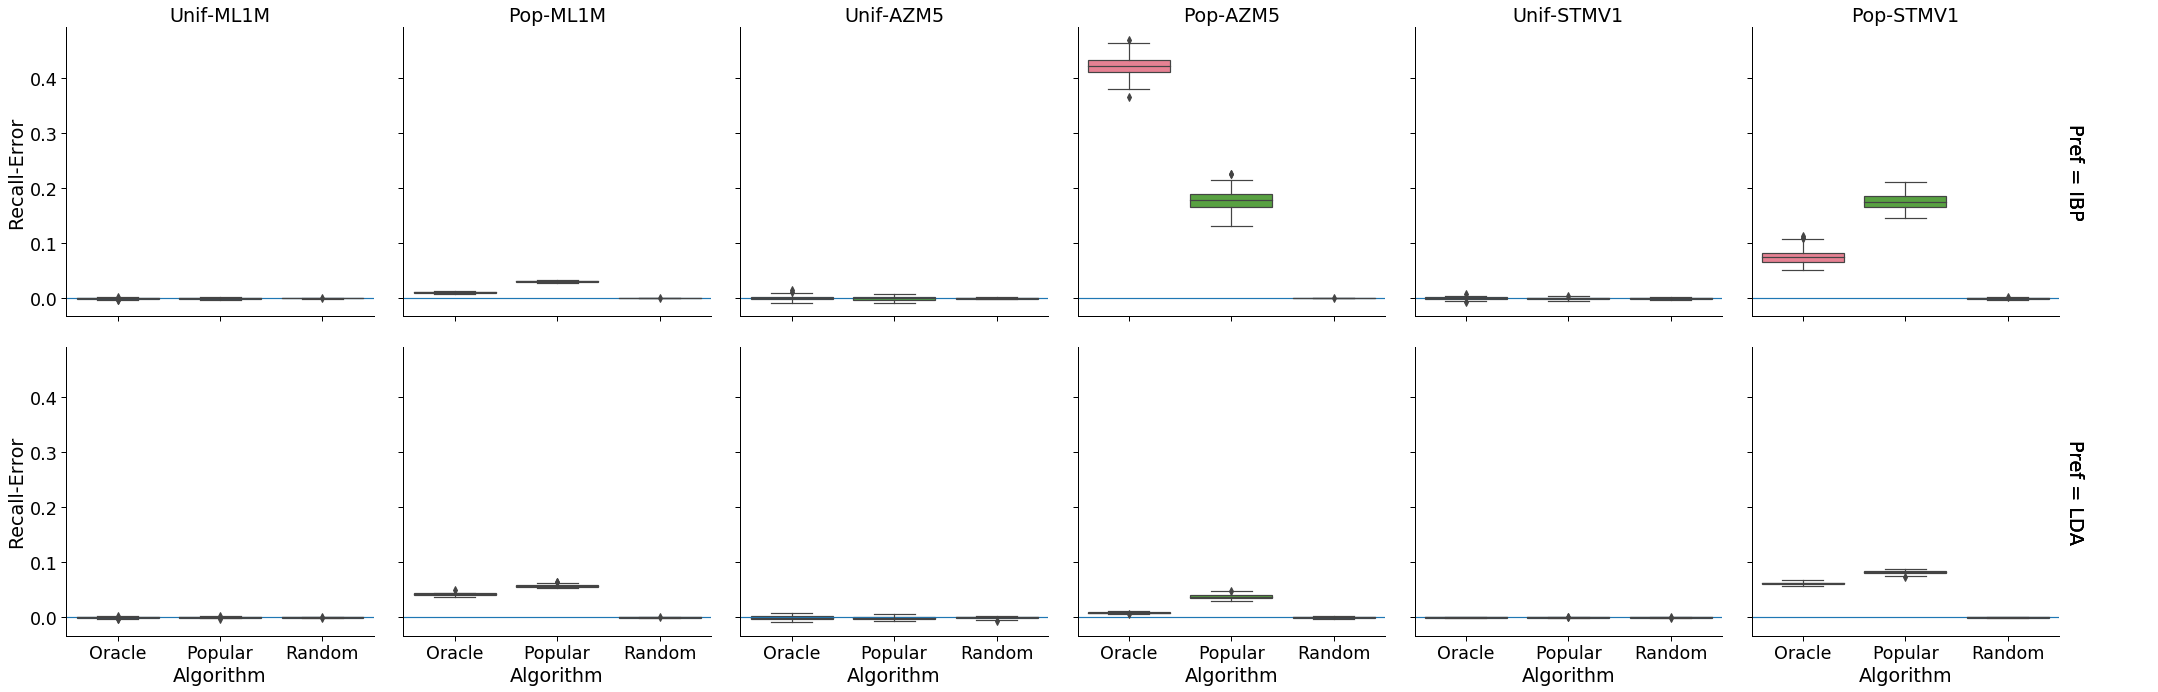

In [58]:
metric = 'Recall'
data2plot = best_fit_results[best_fit_results['metric'] == metric]
data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})
# data2plot.head()

with sns.plotting_context('paper', 2):
    g = sns.FacetGrid(data2plot, col='Obs-Data', row='Pref', height=5, margin_titles=True, sharey=True, sharex=True,
                      col_order=['Unif-ML1M', 'Pop-ML1M', 'Unif-AZM5', 'Pop-AZM5', 'Unif-STMV1', 'Pop-STMV1'], 
                      row_order=['IBP', 'LDA'])
    g = g.map(plt.axhline)
    g = (g.map(sns.boxplot, 'Algorithm', f'{metric}-Error',
               palette='husl',
               order=['Oracle', 'Popular', 'Random'], 
               hue_order=['ML1M', 'AZM5', 'STMV1'])
         .add_legend().set_titles(col_template="{col_name}"))

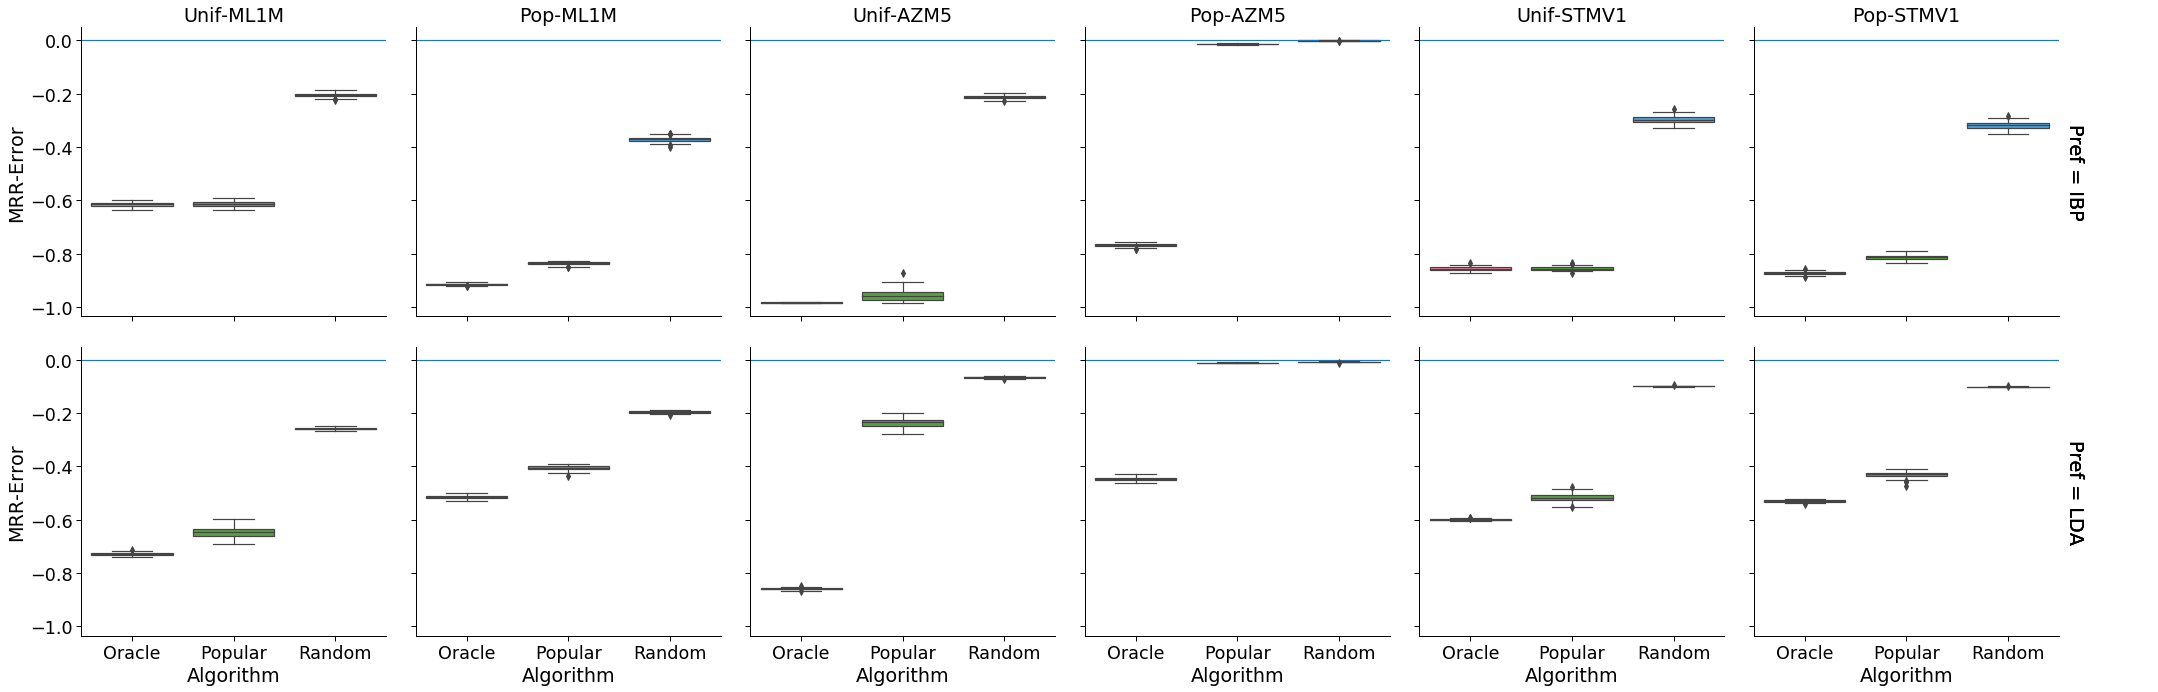

In [59]:
metric = 'MRR'
data2plot = best_fit_results[best_fit_results['metric'] == metric]
data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})
# data2plot.head()

with sns.plotting_context('paper', 2):
    g = sns.FacetGrid(data2plot, col='Obs-Data', row='Pref', height=5, margin_titles=True, sharey=True, sharex=True,
                      col_order=['Unif-ML1M', 'Pop-ML1M', 'Unif-AZM5', 'Pop-AZM5', 'Unif-STMV1', 'Pop-STMV1'], 
                      row_order=['IBP', 'LDA'])
    g = g.map(plt.axhline)
    g = (g.map(sns.boxplot, 'Algorithm', f'{metric}-Error',
               palette='husl',
               order=['Oracle', 'Popular', 'Random'], 
               hue_order=['ML1M', 'AZM5', 'STMV1'])
         .add_legend().set_titles(col_template="{col_name}"))

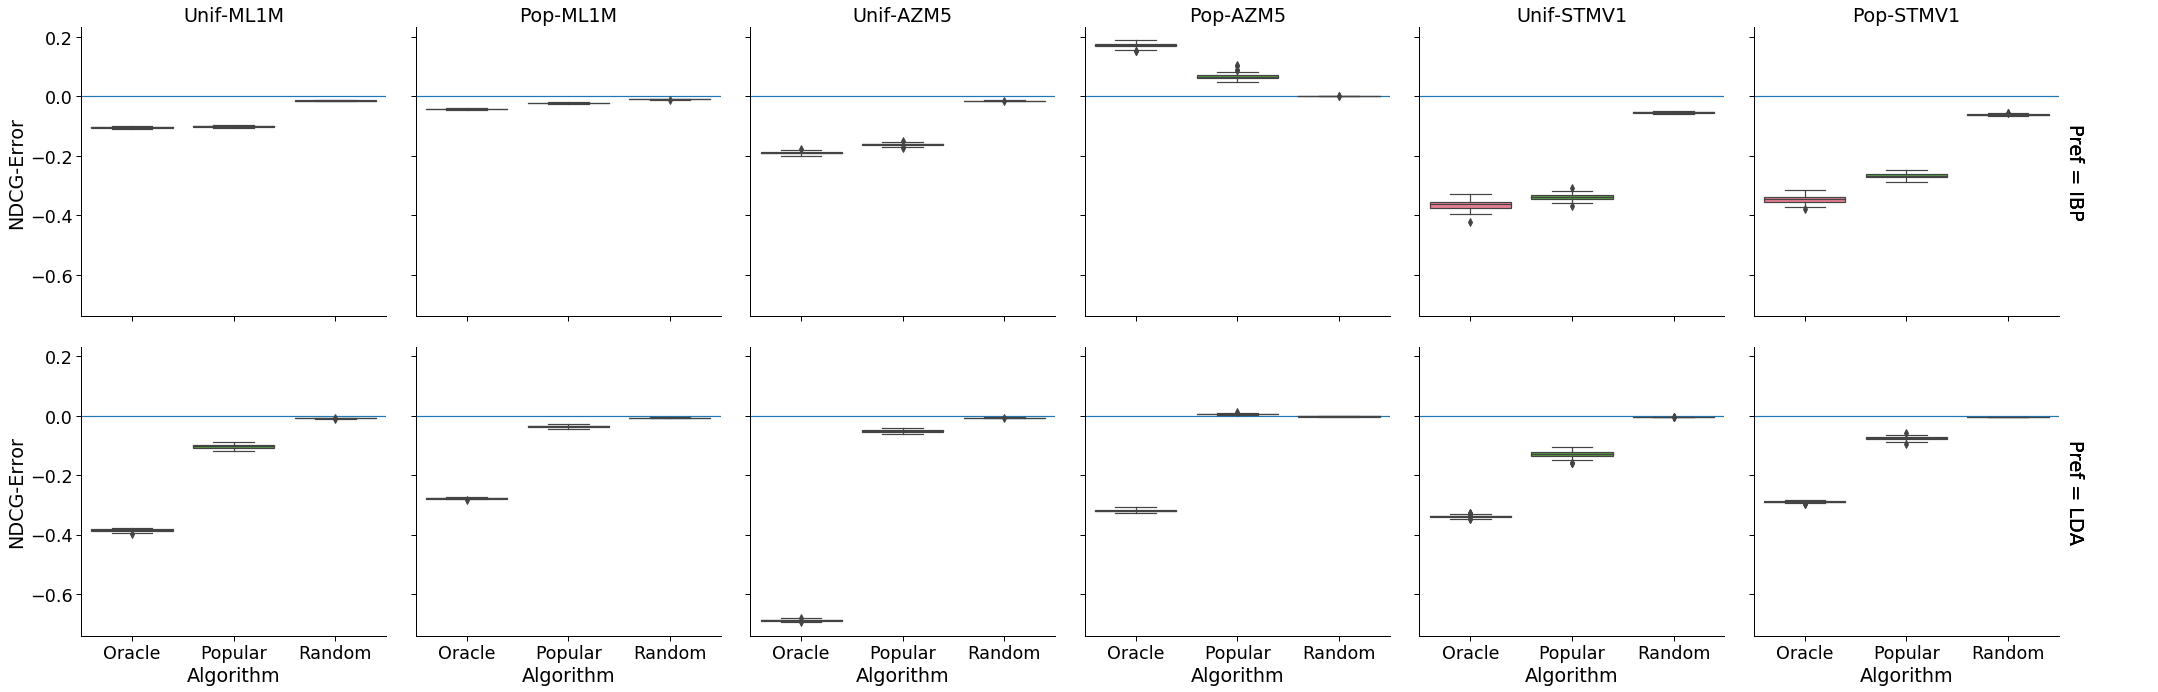

In [13]:
metric = 'NDCG'
data2plot = best_fit_results[best_fit_results['metric'] == metric]
data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})
# data2plot.head()

with sns.plotting_context('paper', 2):
    g = sns.FacetGrid(data2plot, col='Obs-Data', row='Pref', height=5, margin_titles=True, sharey=True, sharex=True,
                      col_order=['Unif-ML1M', 'Pop-ML1M', 'Unif-AZM5', 'Pop-AZM5', 'Unif-STMV1', 'Pop-STMV1'], 
                      row_order=['IBP', 'LDA'])
    g = g.map(plt.axhline)
    g = (g.map(sns.boxplot, 'Algorithm', f'{metric}-Error',
               palette='husl',
               order=['Oracle', 'Popular', 'Random'], 
               hue_order=['ML1M', 'AZM5', 'STMV1'])
         .add_legend().set_titles(col_template="{col_name}"))

### Dist plot 

In [64]:
def plot_dist(**kwargs):
    data = kwargs.pop('data')
    for algo in data['Algorithm'].unique():
        sns.distplot(data[data['Algorithm'] == algo][f'{metric}-Error'], label=algo, kde=False, vertical=True)
        plt.axhline(data[data['Algorithm'] == algo][f'{metric}-Error'].mean())
    plt.axhline()

In [65]:
data2plot.head()

,Algorithm,observation,preference,no,Pref,Obs,Data,NDCG-Error,metric,model,Obs-Data
3600,Oracle,0.265433,0.544390,0,LDA,Pop,ML1M,-0.278958,NDCG,LDA-Pop,Pop-ML1M
3601,Popular,0.124183,0.165269,0,LDA,Pop,ML1M,-0.041086,NDCG,LDA-Pop,Pop-ML1M
3602,Random,0.013394,0.020034,0,LDA,Pop,ML1M,-0.006640,NDCG,LDA-Pop,Pop-ML1M
3603,Oracle,0.259632,0.536893,1,LDA,Pop,ML1M,-0.277261,NDCG,LDA-Pop,Pop-ML1M
3604,Popular,0.111348,0.147110,1,LDA,Pop,ML1M,-0.035761,NDCG,LDA-Pop,Pop-ML1M


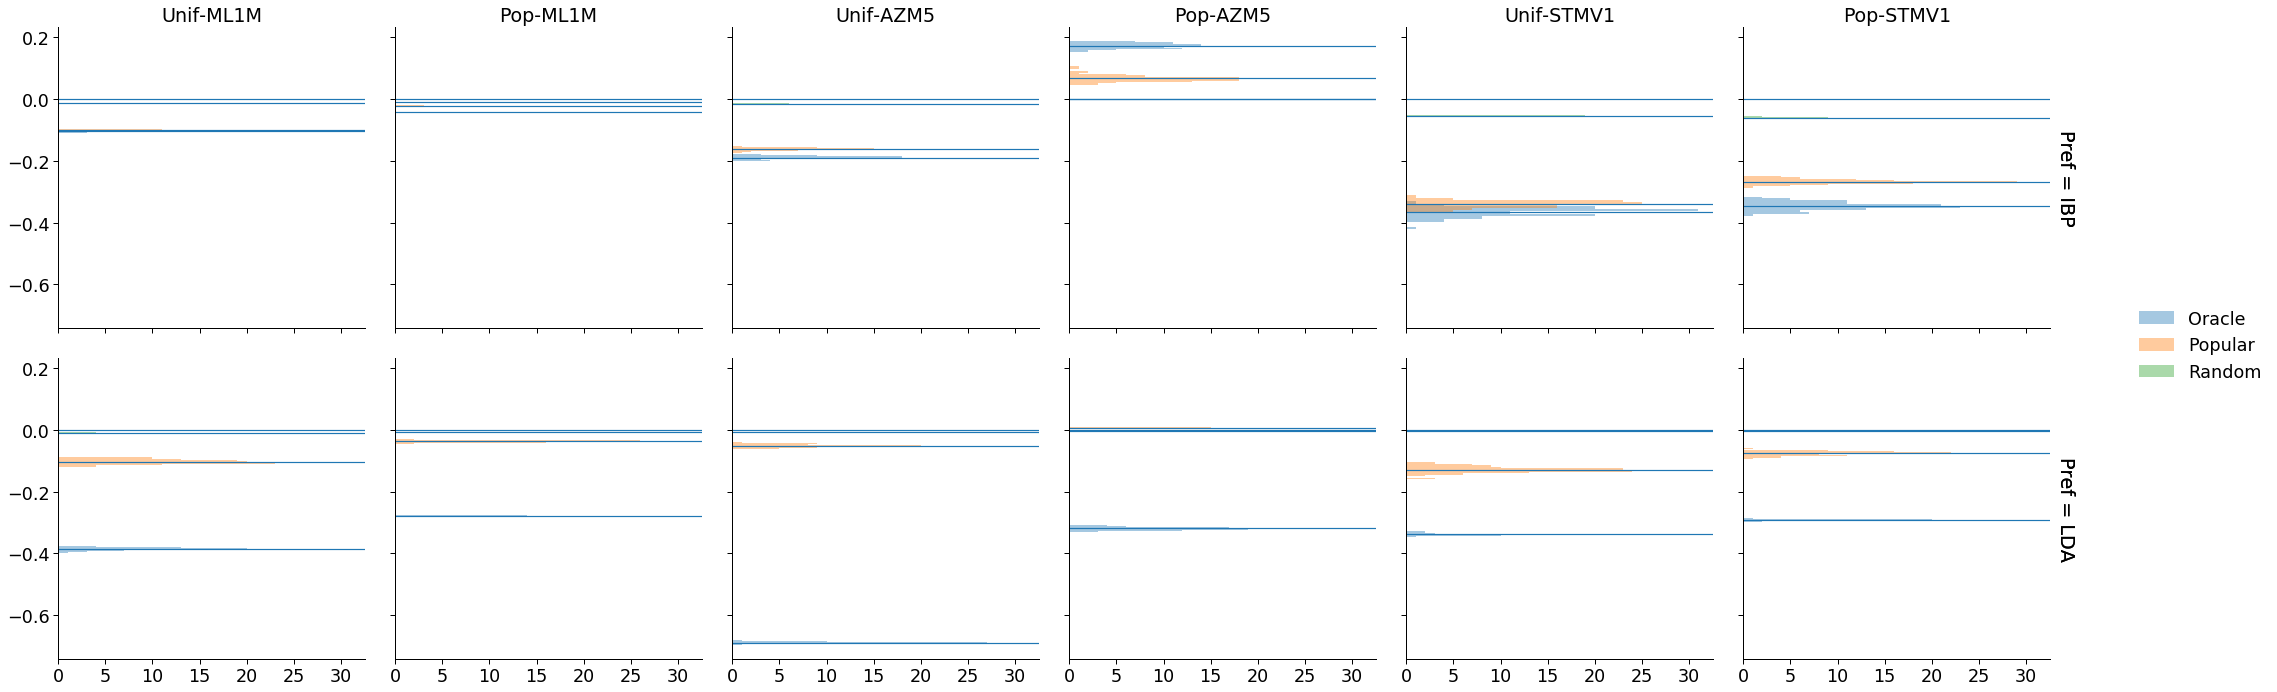

In [66]:
with sns.plotting_context('paper', 2):
    g = sns.FacetGrid(data2plot, col='Obs-Data', row='Pref', height=5, margin_titles=True, sharey=True, sharex=True,
                      col_order=['Unif-ML1M', 'Pop-ML1M', 'Unif-AZM5', 'Pop-AZM5', 'Unif-STMV1', 'Pop-STMV1'], 
                      row_order=['IBP', 'LDA'])
    g = (g.map_dataframe(plot_dist)
         .add_legend().set_titles(col_template="{col_name}"))

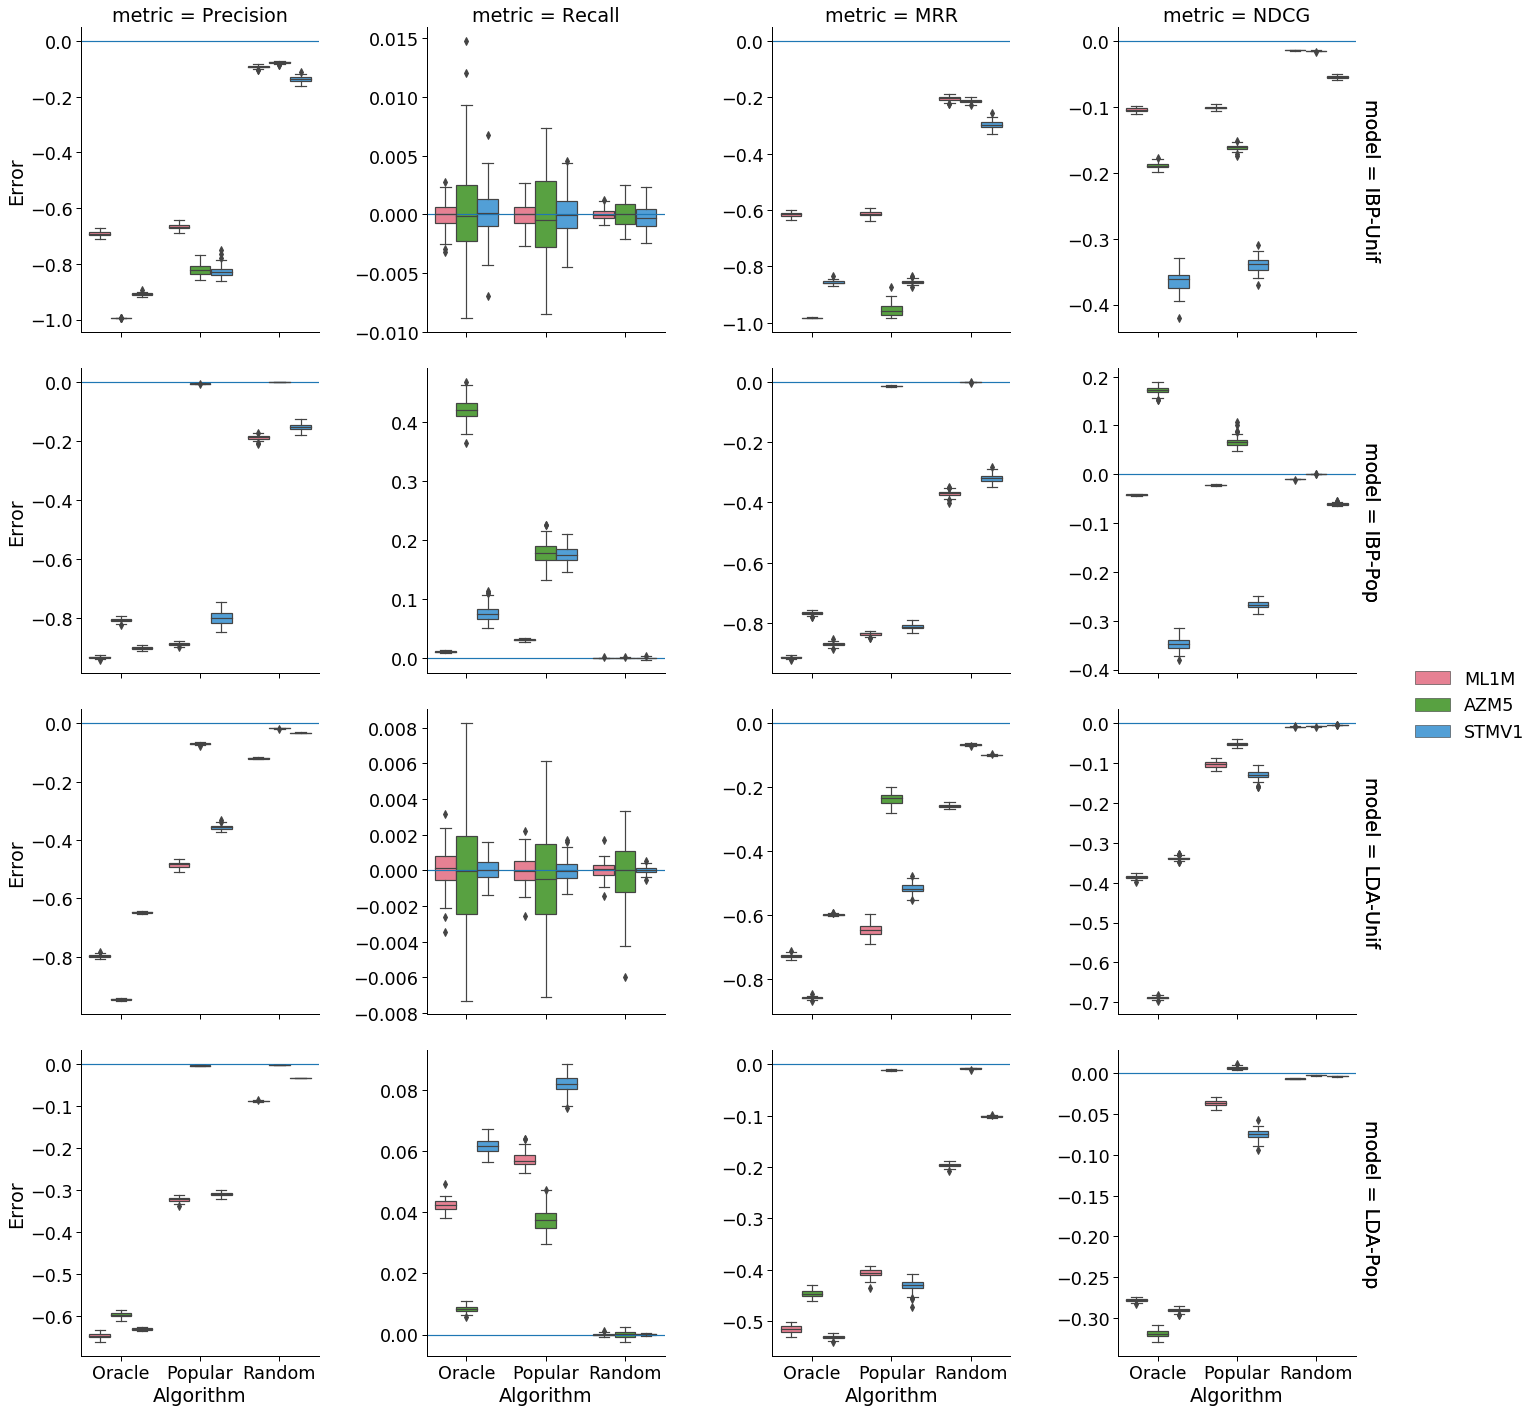

In [67]:
with sns.plotting_context('paper', 2):
    g = sns.FacetGrid(best_fit_results, col='metric', row='model', height=5, margin_titles=True, sharey=False, sharex=True,
                     col_order=['Precision', 'Recall', 'MRR', 'NDCG'], row_order=['IBP-Unif', 'IBP-Pop', 'LDA-Unif', 'LDA-Pop'])
    g = g.map(plt.axhline)
    g.map(sns.boxplot, 'Algorithm', 'Error', 'Data',
          palette='husl',
          order=['Oracle', 'Popular', 'Random'], 
          hue_order=['ML1M', 'AZM5', 'STMV1']).add_legend()

In [16]:
data2plot.head()

,Algorithm,observation,preference,no,Pref,Obs,Data,Precision-Error,metric,model,Obs-Data
0,Oracle,0.353980,1.000000,0,LDA,Pop,ML1M,-0.646020,Precision,LDA-Pop,Pop-ML1M
1,Popular,0.119106,0.441086,0,LDA,Pop,ML1M,-0.321980,Precision,LDA-Pop,Pop-ML1M
2,Random,0.015805,0.104579,0,LDA,Pop,ML1M,-0.088775,Precision,LDA-Pop,Pop-ML1M
3,Oracle,0.351831,1.000000,1,LDA,Pop,ML1M,-0.648169,Precision,LDA-Pop,Pop-ML1M
4,Popular,0.110563,0.424295,1,LDA,Pop,ML1M,-0.313732,Precision,LDA-Pop,Pop-ML1M


### Point plots

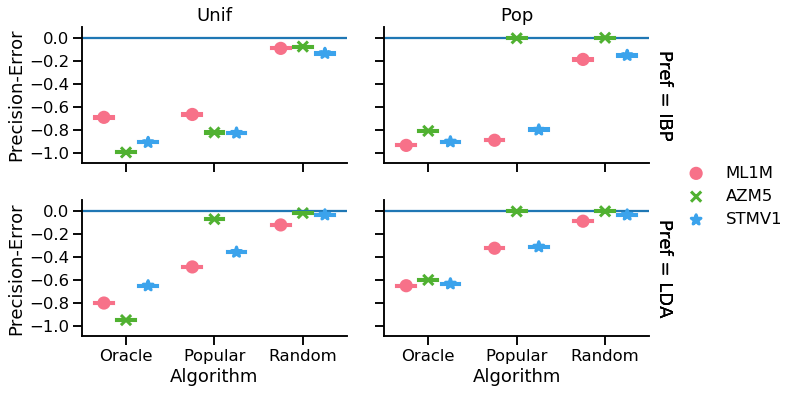

In [22]:
metric = 'Precision'
data2plot = best_fit_results[best_fit_results['metric'] == metric]
data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})
data2plot.head()

with sns.plotting_context('talk', 1):
# with plt.style.context('ggplot', 2):
    g = sns.FacetGrid(data2plot, col='Obs', row='Pref', height=2.9, aspect=1.7, margin_titles=True, sharey=True, sharex=True,
                      col_order=['Unif', 'Pop'], 
                      row_order=['IBP', 'LDA'])
    g = g.map(plt.axhline)
    g = (g.map_dataframe(sns.pointplot, 'Algorithm', f'{metric}-Error', hue='Data',
                         hue_order=['ML1M', 'AZM5', 'STMV1'],
                         order=['Oracle', 'Popular', 'Random'],
                         palette='husl',
                         join=False,
                         dodge=0.5,
                         markers=["o", "x", "*"],
                         ci=95,
                         capsize=.2)
         .add_legend().set_titles(col_template="{col_name}"))
    g.savefig(f'build/figures/{metric.lower()}-error-point.pdf')

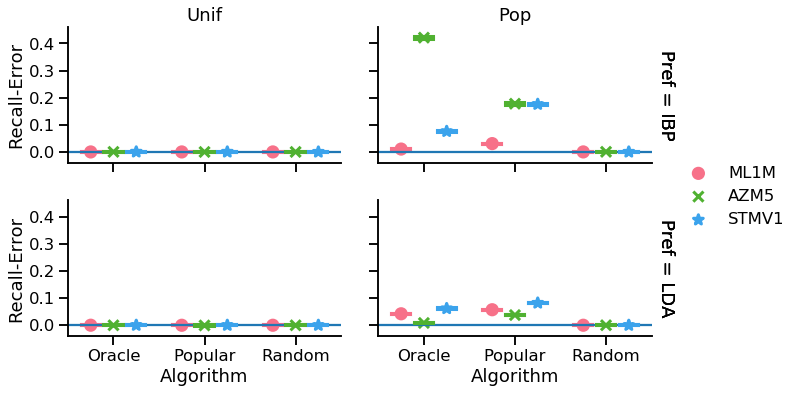

In [23]:
metric = 'Recall'
data2plot = best_fit_results[best_fit_results['metric'] == metric]
data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})
data2plot.head()

with sns.plotting_context('talk', 1):
# with plt.style.context('ggplot', 2):
    g = sns.FacetGrid(data2plot, col='Obs', row='Pref', height=2.9, aspect=1.7, margin_titles=True, sharey=True, sharex=True,
                      col_order=['Unif', 'Pop'], 
                      row_order=['IBP', 'LDA'])
    g = g.map(plt.axhline)
    g = (g.map_dataframe(sns.pointplot, 'Algorithm', f'{metric}-Error', hue='Data',
                         hue_order=['ML1M', 'AZM5', 'STMV1'],
                         order=['Oracle', 'Popular', 'Random'],
                         palette='husl',
                         join=False,
                         dodge=0.5,
                         markers=["o", "x", "*"],
                         ci=95,
                         capsize=.2)
         .add_legend().set_titles(col_template="{col_name}"))
    g.savefig(f'build/figures/{metric.lower()}-error-point.pdf')

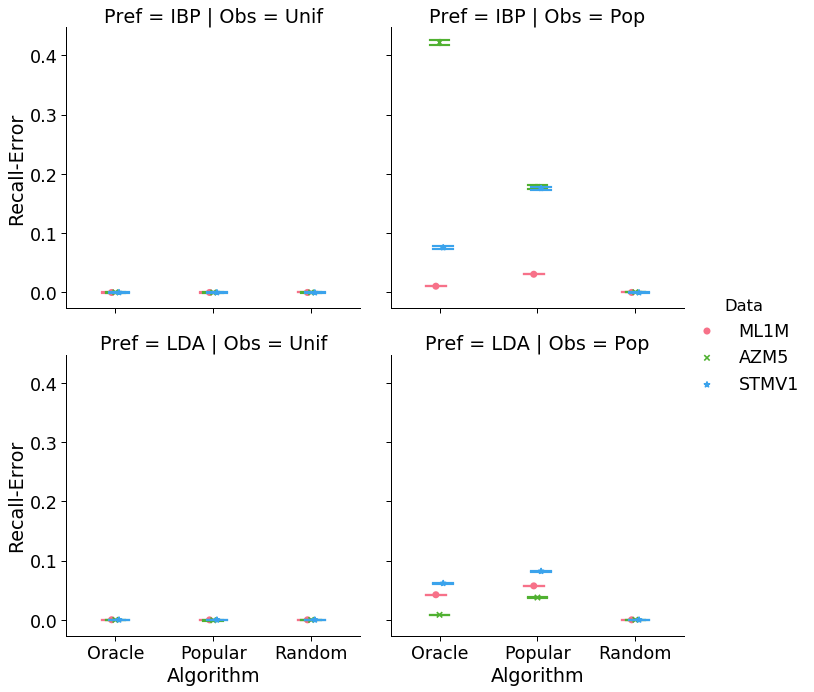

In [63]:
with sns.plotting_context('paper', 2):
    g = sns.catplot(x="Algorithm", y=f'{metric}-Error', 
                    hue='Data',col="Obs", row='Pref',
                    data=data2plot, kind="point",
                    col_order=['Unif', 'Pop'], 
                    row_order=['IBP', 'LDA'],
                    dodge=True,
                    height=5, aspect=1,
                    hue_order=['ML1M', 'AZM5', 'STMV1'],
                    order=['Oracle', 'Popular', 'Random'],
                    palette='husl',
                    join=False,
                    markers=["o", "x", "*"],
                    ci=95,
                    capsize=.2)

In [22]:
data2plot.groupby(['Data', 'metric', 'Pref', 'Obs', 'Algorithm']).mean()

observation  preference    no  MRR-Error
Data  metric Pref Obs  Algorithm                                          
AZM5  MRR    IBP  Pop  Oracle        0.233746    1.000000  49.5  -0.766254
                       Popular       0.049362    0.062292  49.5  -0.012930
                       Random        0.000074    0.000523  49.5  -0.000449
                  Unif Oracle        0.017449    1.000000  49.5  -0.982551
                       Popular       0.015451    0.970825  49.5  -0.955374
                       Random        0.001337    0.213254  49.5  -0.211917
             LDA  Pop  Oracle        0.553498    1.000000  49.5  -0.446502
                       Popular       0.013899    0.025307  49.5  -0.011408
                       Random        0.002505    0.010565  49.5  -0.008060
                  Unif Oracle        0.140380    1.000000  49.5  -0.859620
                       Popular       0.013897    0.251022  49.5  -0.237125
                       Random        0.002934    0.069349  49.5  -0.066415
ML1M  MRR    IBP  Pop  Oracle        0.086175    1.000000  49.5  -0.913825
                       Popular       0.160119    0.995830  49.5  -0.835711
                       Random        0.021958    0.392083  49.5  -0.370125
                  Unif Oracle        0.385225    1.000000  49.5  -0.614775
                       Popular       0.380557    0.993720  49.5  -0.613163
                       Random        0.054024    0.258202  49.5  -0.204178
             LDA  Pop  Oracle        0.485224    1.000000  49.5  -0.514776
                       Popular       0.348721    0.754906  49.5  -0.406185
                       Random        0.055395    0.251798  49.5  -0.196402
                  Unif Oracle        0.271401    1.000000  49.5  -0.728599
                       Popular       0.179841    0.827834  49.5  -0.647993
                       Random        0.042160    0.300231  49.5  -0.258071
STMV1 MRR    IBP  Pop  Oracle        0.128384    1.000000  49.5  -0.871616
                       Popular       0.184382    0.996898  49.5  -0.812516
                       Random        0.024301    0.344283  49.5  -0.319982
                  Unif Oracle        0.143809    1.000000  49.5  -0.856191
                       Popular       0.141054    0.996241  49.5  -0.855187
                       Random        0.021559    0.317916  49.5  -0.296357
             LDA  Pop  Oracle        0.470014    1.000000  49.5  -0.529986
                       Popular       0.294236    0.724220  49.5  -0.429984
                       Random        0.020867    0.122192  49.5  -0.101325
                  Unif Oracle        0.400771    1.000000  49.5  -0.599229
                       Popular       0.234169    0.752401  49.5  -0.518232
                       Random        0.020414    0.120109  49.5  -0.099695

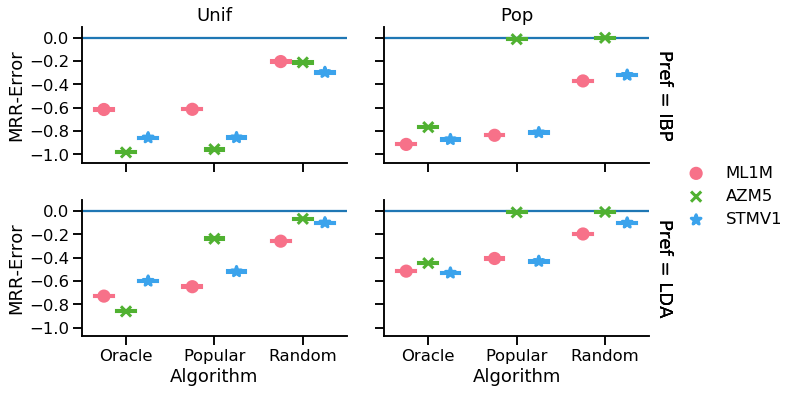

In [24]:
metric = 'MRR'
data2plot = best_fit_results[best_fit_results['metric'] == metric]
data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})
data2plot.head()

with sns.plotting_context('talk', 1):
# with plt.style.context('ggplot', 2):
    g = sns.FacetGrid(data2plot, col='Obs', row='Pref', height=2.9, aspect=1.7, margin_titles=True, sharey=True, sharex=True,
                      col_order=['Unif', 'Pop'], 
                      row_order=['IBP', 'LDA'])
    g = g.map(plt.axhline)
    g = (g.map_dataframe(sns.pointplot, 'Algorithm', f'{metric}-Error', hue='Data',
                         hue_order=['ML1M', 'AZM5', 'STMV1'],
                         order=['Oracle', 'Popular', 'Random'],
                         palette='husl',
                         join=False,
                         dodge=0.5,
                         markers=["o", "x", "*"],
                         ci=95,
                         capsize=.2)
         .add_legend().set_titles(col_template="{col_name}"))
    g.savefig(f'build/figures/{metric.lower()}-error-point.pdf')

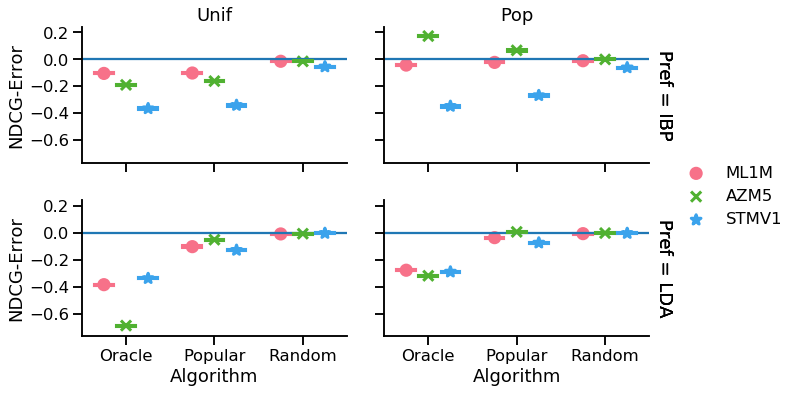

In [25]:
metric = 'NDCG'
data2plot = best_fit_results[best_fit_results['metric'] == metric]
data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})
data2plot.head()

with sns.plotting_context('talk', 1):
# with plt.style.context('ggplot', 2):
    g = sns.FacetGrid(data2plot, col='Obs', row='Pref', height=2.9, aspect=1.7, margin_titles=True, sharey=True, sharex=True,
                      col_order=['Unif', 'Pop'], 
                      row_order=['IBP', 'LDA'])
    g = g.map(plt.axhline)
    g = (g.map_dataframe(sns.pointplot, 'Algorithm', f'{metric}-Error', hue='Data',
                         hue_order=['ML1M', 'AZM5', 'STMV1'],
                         order=['Oracle', 'Popular', 'Random'],
                         palette='husl',
                         join=False,
                         dodge=0.5,
                         markers=["o", "x", "*"],
                         ci=95,
                         capsize=.2)
         .add_legend().set_titles(col_template="{col_name}"))
    g.savefig(f'build/figures/{metric.lower()}-error-point.pdf')

In [38]:
def rank_algos(data, metric='Precision', stats_to_tune='icorr', algo_pair=('Oracle', 'Popular')):
    data_pivot = data.drop(['Error', 'stats_to_tune'], axis=1, errors='ignore').pivot_table(index=['no', 'Pref', 'Obs', 'Data'], columns='Algorithm')
    algo1, algo2 = algo_pair
    obs_rank = (data_pivot['observation'][algo1] >= data_pivot['observation'][algo2])
    obs_rank = obs_rank.groupby(level=['Pref', 'Obs', 'Data']).sum().rename('observation')
    pref_rank = (data_pivot['preference'][algo1] >= data_pivot['preference'][algo2])
    pref_rank = pref_rank.groupby(level=['Pref', 'Obs', 'Data']).sum().rename('preference')
    return pd.concat([obs_rank, pref_rank], axis=1).stack().rename('count').reset_index().rename(columns={'level_3': 'data_model'})

In [39]:
def rank_algorithms(data):
    rank_results = []
    for metric in ['Precision', 'Recall', 'MRR', 'NDCG']:
        res = rank_algos(data[data['metric']==metric].drop(['metric', 'model'], axis=1))
        res['metric'] = metric
        rank_results.append(res)
    return pd.concat(rank_results, ignore_index=True)

In [40]:
rank_results = rank_algorithms(best_fit_results)
rank_results = rank_results[rank_results['data_model'] == 'observation']  # comment this line for preference and observation
rank_results['count'] = rank_results['count'].map(lambda x: ''.join([str(int(x)), '%']))
rank_results.pivot_table(index=['Data', 'Pref', 'Obs', 'data_model'], columns='metric', values='count', aggfunc='sum').unstack()[['Precision', 'Recall', 'MRR', 'NDCG']]

metric            Precision      Recall         MRR        NDCG
data_model      observation observation observation observation
Data  Pref Obs                                                 
AZM5  IBP  Pop         100%        100%        100%        100%
           Unif        100%        100%         87%        100%
      LDA  Pop         100%        100%        100%        100%
           Unif        100%        100%        100%        100%
ML1M  IBP  Pop           0%          0%          0%          0%
           Unif        100%        100%         88%        100%
      LDA  Pop         100%        100%        100%        100%
           Unif        100%        100%        100%        100%
STMV1 IBP  Pop         100%          0%          0%          0%
           Unif        100%        100%        100%        100%
      LDA  Pop         100%        100%        100%        100%
           Unif        100%        100%        100%        100%